<a href="https://colab.research.google.com/github/Zoeybiulala/exploreCSR/blob/main/themis_ml.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install themis-ml
!pip install themis-ml
# intall matplotlib
!pip install matplotlib

In [ ]:
#some import
from themis_ml.datasets import german_credit
import matplotlib.pyplot as plt

raw_data = german_credit(raw=True)
raw_data.head()

,status_of_existing_checking_account,duration_in_month,credit_history,purpose,credit_amount,savings_account/bonds,present_employment_since,installment_rate_in_percentage_of_disposable_income,personal_status_and_sex,other_debtors/guarantors,...,property,age_in_years,other_installment_plans,housing,number_of_existing_credits_at_this_bank,job,number_of_people_being_liable_to_provide_maintenance_for,telephone,foreign_worker,credit_risk
0,1,6,critical_account/other_credits_existing_not_at...,radio/television,1169,0,4,4,male_single,none,...,real_estate,67,none,own,2,2,1,1,1,1
1,2,48,existing_credits_paid_back_duly_till_now,radio/television,5951,1,2,2,female_divorced/separated/married,none,...,real_estate,22,none,own,1,2,1,0,1,0
2,0,12,critical_account/other_credits_existing_not_at...,education,2096,1,3,2,male_single,none,...,real_estate,49,none,own,1,1,2,0,1,1
3,1,42,existing_credits_paid_back_duly_till_now,furniture/equipment,7882,1,3,2,male_single,guarantor,...,building_society_savings_agreement/life_insurance,45,none,for free,1,2,2,0,1,1
4,1,24,delay_in_paying_off_in_the_past,car_(new),4870,1,2,3,male_single,none,...,unknown/no_property,53,none,for free,2,2,2,0,1,0


## Measure potentional discrimination 
measured in **mean difference** with respect to a binary target variable **credit rist**. 
Two protected classes are **sex** and **immigration statuts**.

* The target y ∈ {0, 1} where 1 is a beneficial outcome (low credit risk) and 0 is harmful outcome (high credit risk)
* s ∈ {d, a}, where d = 1 is disadvantaged group and a = 0 is an advantaged group

In [ ]:
from themis_ml.metrics import mean_difference
# target variable
# values: 1 = low credit risk, 0 = high credit risk
credit_risk = raw_data["credit_risk"]

# display frequency counts of each value
credit_risk.value_counts()


1    700
0    300
Name: credit_risk, dtype: int64

In [ ]:
# get sex of the individual from the "personal_status_and_sex" column.
# values: 1 = female, 0 = male
sex = raw_data["personal_status_and_sex"].map(
    lambda x: {"male": 0, "female": 1}[x.split("_")[0]])

# display frequency counts of each value
sex.value_counts()

0    690
1    310
Name: personal_status_and_sex, dtype: int64

In [ ]:
# get foreign worker status: 1 = yes, 0 = no
foreign = raw_data["foreign_worker"]

# display frequency counts of each value
foreign.value_counts()

1    963
0     37
Name: foreign_worker, dtype: int64

### mean_difference function: 
Calculate the mean difference and confidence interval.
* 1 is the desireable outcome and 0 is the undesireable outcome.
* where 0 is the advantaged group and 1 is the disadvantaged
* return mean difference between advantaged group and disadvantaged group with error margin


In [ ]:

print("Mean difference scores:")
print("protected class = sex: %0.03f, 95%% CI [%0.03f-%0.03f]" %
      mean_difference(credit_risk, sex))
# 0.0748013090229
print("protected class = foreign: %0.03f, 95%% CI [%0.03f-%0.03f]" %
      mean_difference(credit_risk, foreign))
# 0.199264685246

Mean difference scores:
protected class = sex: 0.075, 95% CI [0.013-0.136]
protected class = foreign: 0.199, 95% CI [0.049-0.349]


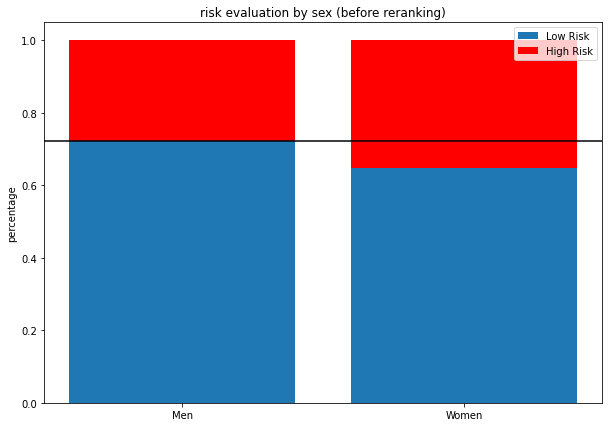

In [ ]:
low_risk = credit_risk[credit_risk == 1]
high_risk = credit_risk[credit_risk == 0]
men_low_risk = low_risk[sex==0].sum() / (sex==0).sum()
men_high_risk = high_risk[sex==0].count() / (sex==0).sum()
women_low_risk = low_risk[sex==1].sum() / (sex==1).sum()
women_high_risk = high_risk[sex==1].count() / (sex==1).sum()
l = [men_low_risk,women_low_risk]
h = [men_high_risk,women_high_risk]

labels = ['Men', 'Women']
fig, ax = plt.subplots(figsize=(10,7))
ax.bar(labels, l ,label='Low Risk')
ax.axhline(men_low_risk, color = 'black')
ax.bar(labels, h, bottom=l,label='High Risk',color='red')
ax.set_title('risk evaluation by sex (before reranking)')
ax.set_ylabel('percentage')
ax.legend()


## De-biasing Experiment
Baseline (B): classifier trained on all available input variables, including protected attributes.

Remove Protected Attribute (RPA): classifier where input variables do not contain protected attributes. This is the naive fairness-aware approach.

Reject-Option Classification (ROC): classifier using the reject-option classification method.

Additive Counterfactually Fair Model (ACF): classifier using the additive counterfactually fair method.

In [ ]:
from sklearn.model_selection import train_test_split

# load model-ready data
training_data = german_credit()
training_data.head()

# define feature sets:
# 1. including protected attributes
features = [
    'duration_in_month', 'credit_amount', 'installment_rate_in_percentage_of_disposable_income',
    'present_residence_since', 'age_in_years', 'number_of_existing_credits_at_this_bank',
    'number_of_people_being_liable_to_provide_maintenance_for', 'status_of_existing_checking_account',
    'savings_account/bonds', 'present_employment_since', 'job', 'telephone', 'foreign_worker',
    'credit_history_all_credits_at_this_bank_paid_back_duly',
    'credit_history_critical_account/other_credits_existing_not_at_this_bank',
    'credit_history_delay_in_paying_off_in_the_past', 'credit_history_existing_credits_paid_back_duly_till_now',
    'credit_history_no_credits_taken/all_credits_paid_back_duly', 'purpose_business',
    'purpose_car_(new)', 'purpose_car_(used)', 'purpose_domestic_appliances', 'purpose_education',
    'purpose_furniture/equipment', 'purpose_others', 'purpose_radio/television',
    'purpose_repairs', 'purpose_retraining', 'personal_status_and_sex_female_divorced/separated/married',
    'personal_status_and_sex_male_divorced/separated', 'personal_status_and_sex_male_married/widowed',
    'personal_status_and_sex_male_single', 'other_debtors/guarantors_co-applicant',
    'other_debtors/guarantors_guarantor', 'other_debtors/guarantors_none',
    'property_building_society_savings_agreement/life_insurance',
    'property_car_or_other', 'property_real_estate', 'property_unknown/no_property',
    'other_installment_plans_bank', 'other_installment_plans_none',
    'other_installment_plans_stores', 'housing_for free', 'housing_own', 'housing_rent',
]
# 2. removing variables related to sex
features_no_sex = [
    f for f in features if f not in [
        'personal_status_and_sex_female_divorced/separated/married',
        'personal_status_and_sex_male_divorced/separated',
        'personal_status_and_sex_male_married/widowed',
        'personal_status_and_sex_male_single']]

# 3. removing variables related to immigration status
features_no_frn = [f for f in features if f != "foreign_worker"]


##training data
X = training_data[features].values
print(X.shape)
X_no_sex = training_data[features_no_sex].values
print(X_no_sex.shape)
X_no_frn = training_data[features_no_frn].values
print(X_no_frn.shape)
y = training_data["credit_risk"].values
s_sex = sex.values
s_frn = foreign.values

(1000, 45)
(1000, 41)
(1000, 44)


In [ ]:
import pandas as pd

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.base import clone

from themis_ml.postprocessing.reject_option_classification import \
    SingleROClassifier
from themis_ml.linear_model import LinearACFClassifier

METRICS_COLUMNS = [
    "mean_diff_sex", "mean_diff_foreign", "auc_sex", "auc_foreign"]


def run_experiment_iteration(
        X, X_no_sex, X_no_frn, y, s_sex, s_frn, train, test):
    """Run the experiment on a particular set of train and test indices."""
    
    # store our metrics here. This will be a list of lists, where the inner
    # list is contains the following metadata:
    # - "name"
    # - fairness metric with respect to sex
    # - fairness metric with respect to foreign status
    # - utility metric with respect to sex
    # - utility metric with respect to foreign status
    metrics = []

    # define our model.
    logistic_clf = LogisticRegression(penalty="l2", C=0.001, class_weight="balanced")
    baseline_clf = logistic_clf
    rpa_clf = logistic_clf
    roc_clf = SingleROClassifier(estimator=logistic_clf)
    acf_clf = LinearACFClassifier(
        target_estimator=logistic_clf,
        binary_residual_type="absolute")

    # train baseline model
    baseline_clf.fit(X[train], y[train])
    baseline_preds = baseline_clf.predict(X[test])

    baseline_auc = roc_auc_score(y[test], baseline_preds)

    metrics.append([
        "B",
        mean_difference(baseline_preds, s_sex[test])[0],
        mean_difference(baseline_preds, s_frn[test])[0],
        baseline_auc, baseline_auc  # repeated because the two AUC values are the
                                    # same in the baseline case
    ])

    # train "remove protected attributes" model. Here we have to train two
    # seperate ones for sex and foreign status.

    # model trained with no explicitly sex-related variables
    rpa_preds_no_sex = rpa_clf.fit(
        X_no_sex[train], y[train]).predict(X_no_sex[test])
    # model trained with no explicitly foreign-related variables
    rpa_preds_no_frn = rpa_clf.fit(
        X_no_frn[train], y[train]).predict(X_no_frn[test])
   
    metrics.append([
        "RPA",
        mean_difference(rpa_preds_no_sex, s_sex[test])[0],
        mean_difference(rpa_preds_no_frn, s_frn[test])[0],
        roc_auc_score(y[test], rpa_preds_no_sex),
        roc_auc_score(y[test], rpa_preds_no_frn),
    ])

    # train reject-option classification model.
    roc_clf.fit(X[train], y[train])
    roc_preds_sex = roc_clf.predict(X[test], s_sex[test])
    roc_preds_frn = roc_clf.predict(X[test], s_frn[test])
    metrics.append([
        "ROC",
        mean_difference(roc_preds_sex, s_sex[test])[0],
        mean_difference(roc_preds_frn, s_frn[test])[0],
        roc_auc_score(y[test], roc_preds_sex),
        roc_auc_score(y[test], roc_preds_frn),
    ])
     # train additive counterfactually fair model.
    acf_preds_sex = acf_clf.fit(
        X[train], y[train], s_sex[train]).predict(X[test], s_sex[test])
    acf_preds_frn = acf_clf.fit(
        X[train], y[train], s_frn[train]).predict(X[test], s_frn[test])
    metrics.append([
        "ACF",
        mean_difference(acf_preds_sex, s_sex[test])[0],
        mean_difference(acf_preds_frn, s_frn[test])[0],
        roc_auc_score(y[test], acf_preds_sex),
        roc_auc_score(y[test], acf_preds_frn),
    ])

    # convert metrics list of lists into dataframe
    return pd.DataFrame(
        metrics, columns=["condition"] + METRICS_COLUMNS)

In [ ]:
import numpy as np

%matplotlib inline

N_SPLITS = 5
N_REPEATS = 20

# add these two binary variables so that we can stratify the observations
# by protected class
groups = np.add(s_sex, s_frn)

# do 5-fold, 10x repeating cross validation so that we quantify the
# uncertainty around our metrics estimates.
cv = RepeatedStratifiedKFold(
    n_splits=N_SPLITS, n_repeats=N_REPEATS, random_state=41)

metrics = []
print("Running cross-validation experiment...")
for i, (train_idx, test_idx) in enumerate(cv.split(X, y, groups=groups)):
    metrics.append(
        run_experiment_iteration(
            X, X_no_sex, X_no_frn, y, s_sex, s_frn, train_idx, test_idx)
        .assign(rep_fold=i))

# concatenate metrics from all cv-folds
metrics = pd.concat(metrics)



Running cross-validation experiment...


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,
/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression


In [ ]:
# compute mean point estimate for each metric and each condition
group_df = metrics.groupby("condition")
metrics.to_excel(excel_writer = "./test.xlsx")
sum_metrics = (
    group_df
    [METRICS_COLUMNS].sum()
)
count_metrics = (
    group_df[METRICS_COLUMNS].count()
)
percentage_metrics = sum_metrics/count_metrics
# compute standard error of the mean
# stderr_metrics = (
#     group_df
#     [METRICS_COLUMNS].std()
# ) / np.sqrt(N_REPEATS * N_SPLITS)

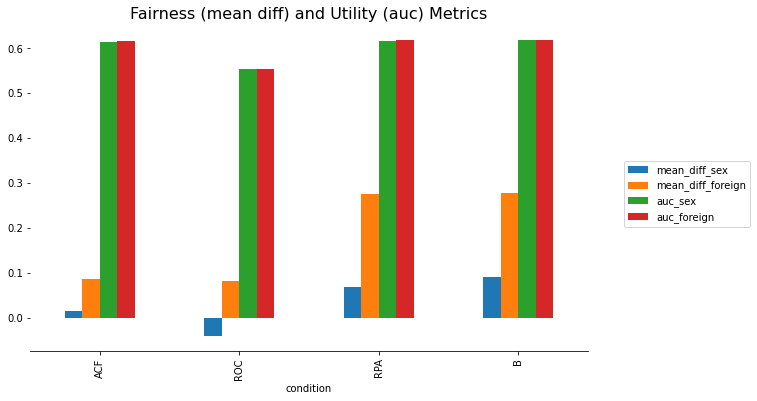

In [ ]:
# plot vertical bar chart
ax = percentage_metrics.loc[reversed(["B", "RPA", "ROC", "ACF"])].plot(
    kind="bar", figsize=(10, 6),
    legend=False);
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 0.6))
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.tick_params(axis='y', which='both', left='off')
ax.set_title(
    "Fairness (mean diff) and Utility (auc) Metrics", fontsize=16);
    

In [ ]:
sum_metrics.loc[["B", "RPA", "ROC", "ACF"]].rename(
    columns=lambda x: "mean(%s)" % x)

,mean(mean_diff_sex),mean(mean_diff_foreign),mean(auc_sex),mean(auc_foreign)
condition,,,,
B,9.133776,27.772009,61.830952,61.830952
RPA,6.954618,27.674458,61.569048,61.886905
ROC,-4.038241,8.239177,55.416667,55.416667
ACF,1.640677,8.847651,61.427381,61.572619
